In [1]:
from huggingface_hub import login

login()

import torch
#################################### For Image ####################################
from PIL import Image
import numpy as np
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
# Load the model
model = build_sam3_image_model(enable_inst_interactivity=True)
processor = Sam3Processor(model)
# Load an image

points = np.array([[380, 150], [290, 250]])
labels = np.array([1, 1])  # 1 for foreground points
image = Image.open("C:\\Users\\domin\\OneDrive\\Seminar\\code\\000000077595.jpg")
inference_state = processor.set_image(image)

In [9]:
# Prompt the model with text
masks, scores, logits = model.predict_inst(
    inference_state,
    point_coords=points,
    point_labels=labels,
    multimask_output=False,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [10]:
import numpy as np
import matplotlib

def overlay_masks(image, masks):
    image = image.convert("RGBA")
    
    # Handle different mask shapes - squeeze out batch and channel dimensions if present
    if len(masks.shape) == 4:
        masks = masks.squeeze(0)  # Remove batch dimension
    if len(masks.shape) == 3 and masks.shape[0] == 1:
        masks = masks.squeeze(0)  # Remove channel dimension if it's 1
    
    # Convert to numpy and scale to 0-255
    masks_np = 255 * masks.astype(np.uint8)
    
    # If we have a single mask, add a dimension
    if len(masks_np.shape) == 2:
        masks_np = masks_np[np.newaxis, ...]
    
    n_masks = masks_np.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks_np, colors):
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image

In [7]:
# Check the shape of masks
print(f"Masks shape: {masks.shape}")
print(f"Image size: {image.size}")

Masks shape: (3, 425, 640)
Image size: (640, 425)


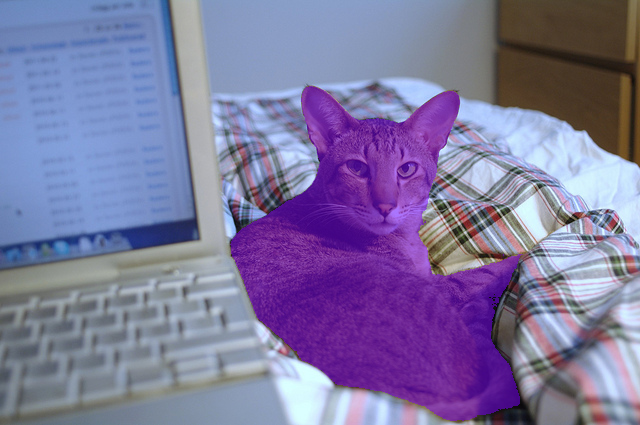

In [11]:
# Visualize the segmentation results
result_image = overlay_masks(image, masks)
result_image